# Logistic Regression

In [5]:
import pandas as pd
import numpy as np
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform

In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from utils import load_and_prepare_data, evaluate_metrics, plot_roc_curve, optimize_threshold

In [3]:
df = pd.read_parquet("../diabetes_dataset_prepared.parquet")
X_train, X_test, y_train, y_test = load_and_prepare_data(df)

We will start with a randomized search to narrow down the scope.

In [6]:
parameters = {
    "C": uniform(0.01, 10),
    "penalty": ["l1", "l2", "elasticnet"],
    "l1_ratio": uniform(0, 1)
}

gridsearch = RandomizedSearchCV(
    LogisticRegression(solver="saga", max_iter=3000), 
    parameters, 
    n_iter=50, 
    cv=5, 
    scoring="f1", 
    n_jobs=-1, 
    verbose=1, 
    random_state=42
)

gridsearch.fit(X_train, y_train)

C = gridsearch.best_params_["C"]
penalty = gridsearch.best_params_["penalty"]
l1_ratio = gridsearch.best_params_.get("l1_ratio", None)

gridsearch.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Sebastijan\anaconda3\envs\diabetes-insight\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


{'C': np.float64(8.970912999234931),
 'l1_ratio': np.float64(0.3180034749718639),
 'penalty': 'l1'}

l1 penalty does not use l1_ratio, so we will ignore it. We will also assume that elastic net is not going to be optimal, and therefore we will ignore it in the next search. Now, we will take a look at how a logistic regression with these parameters performs.

In [7]:
logreg1 = LogisticRegression(C=C, penalty=penalty, solver="saga", max_iter=3000, n_jobs=-1)

lr1 = logreg1.fit(X_train, y_train)

In [8]:
y_train_pred = lr1.predict(X_train)
y_test_pred = lr1.predict(X_test)

Training Set Metrics:


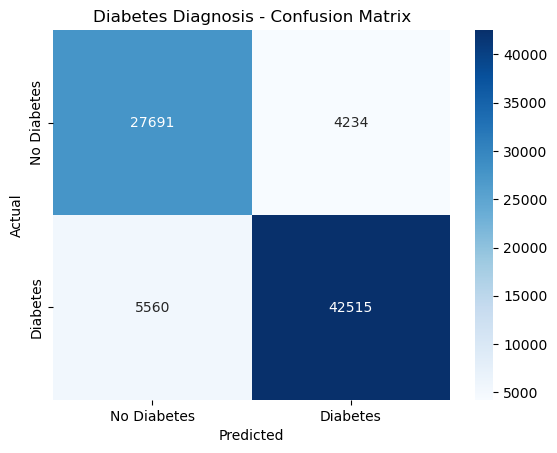

Accuracy: 0.877575
Precision: 0.9094312177800594
Recall: 0.8843473738949558
F1 Score: 0.8967139120897663


Test Set Metrics:


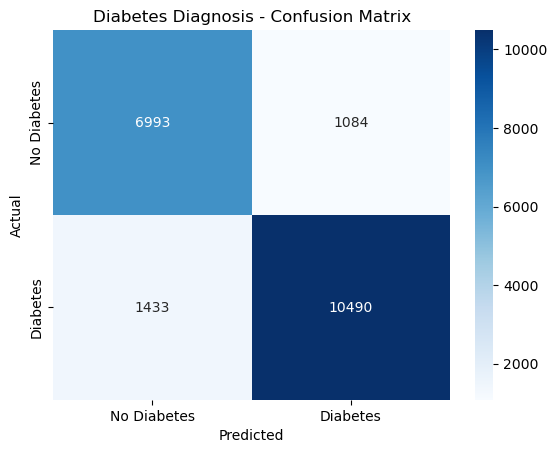

Accuracy: 0.87415
Precision: 0.9063418005875238
Recall: 0.8798121278201795
F1 Score: 0.8928799421202707


In [9]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

Logistic regression already gives us better results than KNN. Let us try to find better hyperparameters.

In [10]:
parameters = {
    "C": uniform(7.5, 12.5),
    "penalty": ["l1", "l2"]
}

gridsearch = RandomizedSearchCV(
    LogisticRegression(solver="saga", max_iter=3000), 
    parameters, 
    n_iter=50, 
    cv=5, 
    scoring="f1", 
    n_jobs=-1, 
    verbose=1, 
    random_state=42
)

gridsearch.fit(X_train, y_train)

C = gridsearch.best_params_["C"]
penalty = gridsearch.best_params_["penalty"]

gridsearch.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'C': np.float64(13.07290941066989), 'penalty': 'l1'}

Once again, l1 penalty seems to be optimal. We will assume that it is indeed optimal from here on.

In [11]:
logreg2 = LogisticRegression(C=C, penalty=penalty, solver="saga", max_iter=3000, n_jobs=-1)

lr2 = logreg2.fit(X_train, y_train)

In [15]:
y_train_pred = lr2.predict(X_train)
y_test_pred = lr2.predict(X_test)

Training Set Metrics:


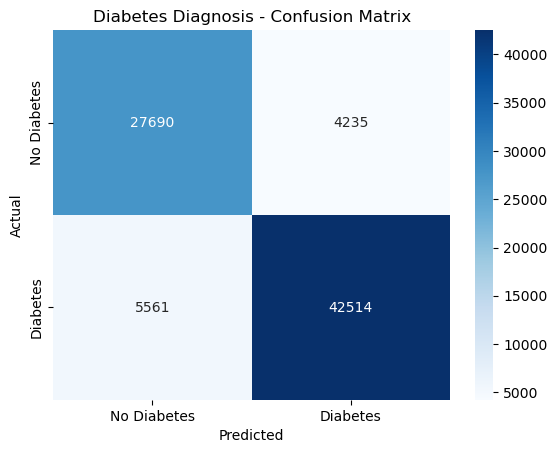

Accuracy: 0.87755
Precision: 0.90940982694817
Recall: 0.8843265730629225
F1 Score: 0.8966928203830254


Test Set Metrics:


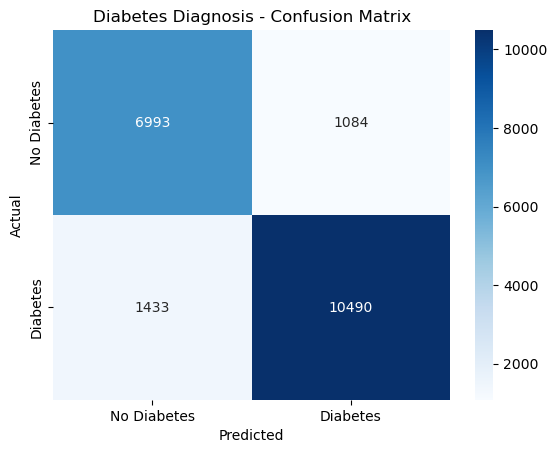

Accuracy: 0.87415
Precision: 0.9063418005875238
Recall: 0.8798121278201795
F1 Score: 0.8928799421202707


In [16]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

The model did not improve at all. We will check if the parameters were set correctly.

In [18]:
lr2.get_params()

{'C': np.float64(13.07290941066989),
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 3000,
 'multi_class': 'deprecated',
 'n_jobs': -1,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

It appears that grid search will likely not result in a better model, but it can be tried nonetheless.

In [20]:
parameters = {
    "C": np.linspace(12, 14, 21)
}

gridsearch = GridSearchCV(
    LogisticRegression(solver="saga", max_iter=4000), 
    parameters, 
    scoring="f1", 
    n_jobs=-1, 
    verbose=1
)

gridsearch.fit(X_train, y_train)

C = gridsearch.best_params_["C"]

gridsearch.best_params_

Fitting 5 folds for each of 21 candidates, totalling 105 fits


{'C': np.float64(13.8)}

In [21]:
logreg3 = LogisticRegression(C=C, penalty="l1", solver="saga", max_iter=4000, n_jobs=-1)

lr3 = logreg3.fit(X_train, y_train)

In [22]:
y_train_pred = lr3.predict(X_train)
y_test_pred = lr3.predict(X_test)

Training Set Metrics:


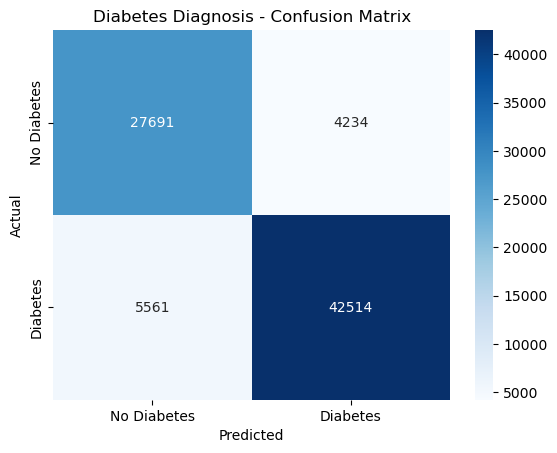

Accuracy: 0.8775625
Precision: 0.9094292803970223
Recall: 0.8843265730629225
F1 Score: 0.8967022768737543


Test Set Metrics:


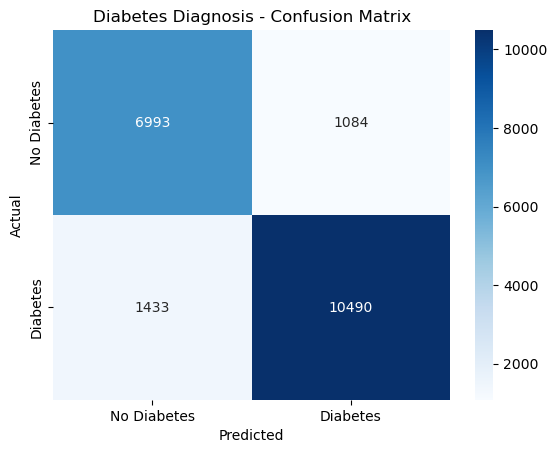

Accuracy: 0.87415
Precision: 0.9063418005875238
Recall: 0.8798121278201795
F1 Score: 0.8928799421202707


In [23]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

Indeed, the model did not improve. We will try to improve it a little further by optimizing the threshold for f1.

In [24]:
y_train_pred_proba = lr3.predict_proba(X_train)
y_test_pred_proba = lr3.predict_proba(X_test)

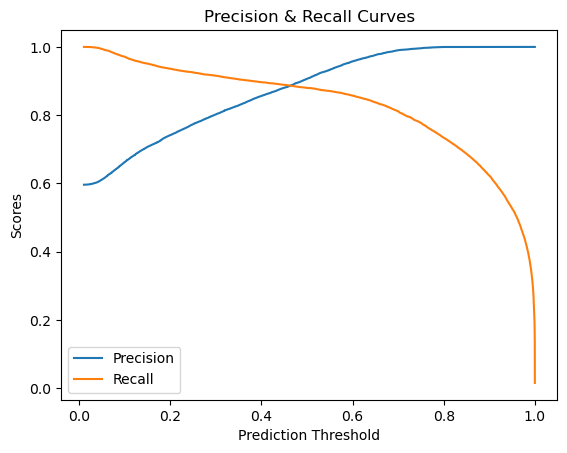

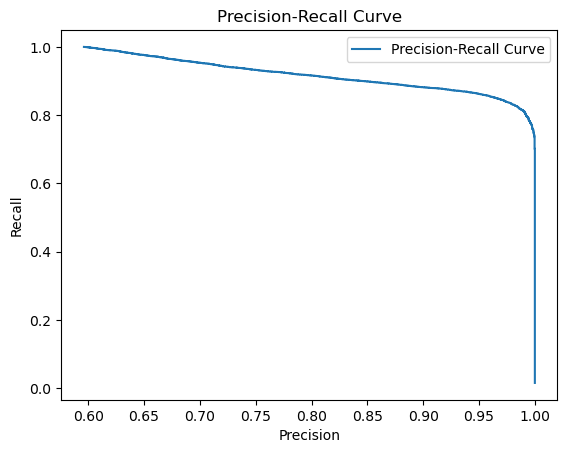

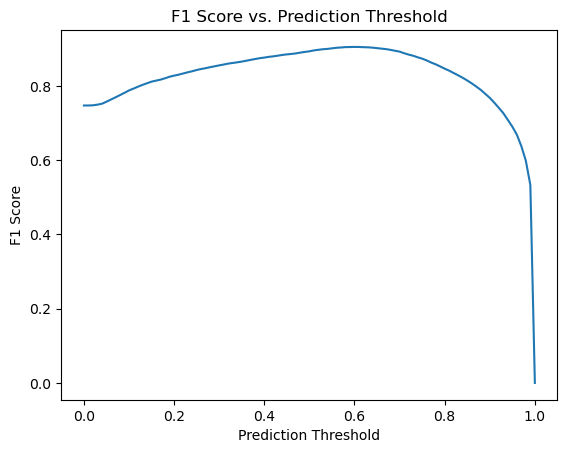

Optimal threshold: 0.6


In [25]:
thresh = optimize_threshold(y_test, y_test_pred_proba[:, 1])
print(f"Optimal threshold: {thresh}")

The optimal threshold sacrifices some recall. We need to evalute the new metrics to see if it is worth it.

Training Set Metrics with Optimized Threshold:


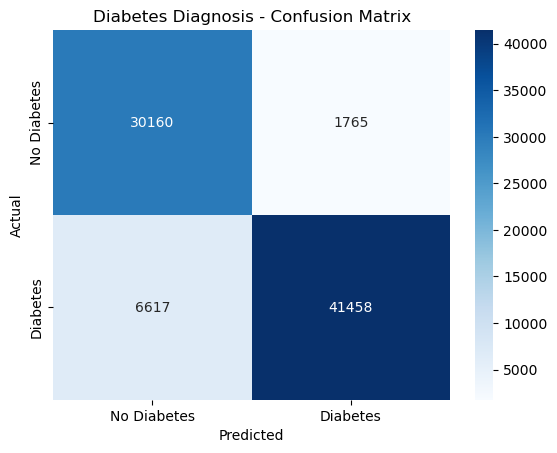

Accuracy: 0.895225
Precision: 0.9591652592369803
Recall: 0.8623608944357775
F1 Score: 0.9081907599290236


Test Set Metrics with Optimized Threshold:


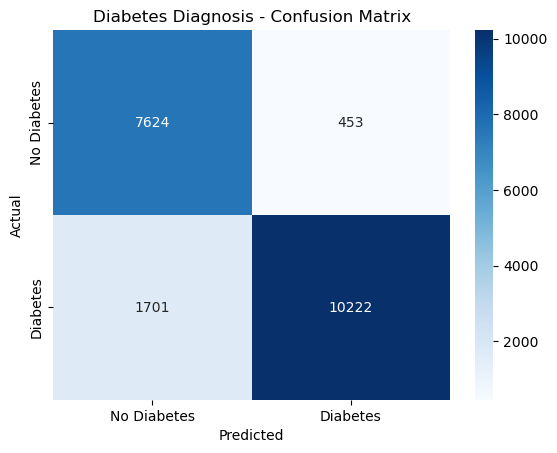

Accuracy: 0.8923
Precision: 0.9575644028103044
Recall: 0.8573345634487964
F1 Score: 0.9046818302504647


In [27]:
preds_train = y_train_pred_proba[:, 1] >= thresh
preds_test = y_test_pred_proba[:, 1] >= thresh
evaluate_metrics(y_train, preds_train, "Training Set Metrics with Optimized Threshold:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, preds_test, "Test Set Metrics with Optimized Threshold:")

By optimizing the threshold, we have significantly improved precision and reached f1 score of over 0.9, while recall dropped only a little bit.

Lastly, let us compare our model to random guess with an roc curve.

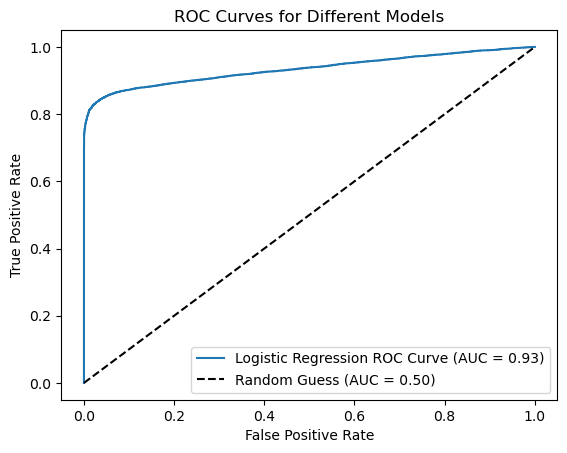

In [28]:
plot_roc_curve(y_test, y_test_pred_proba[:, 1], "Logistic Regression ROC Curve")

Our final auc is the same as that of our best knn model, but our f1 score is slightly better. We will now save the l3 model.

In [29]:
joblib.dump(lr3, "../models/logistic_regression_model.joblib")

['../models/logistic_regression_model.joblib']